In [34]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
cmap_z = 'cividis'
cmap_t = 'RdYlBu_r'
cmap_diff = 'bwr'
cmap_error = 'BrBG'
ds1 = xr.open_mfdataset('/home/humor/sugon/ClimaX/climax-5d.nc', combine='by_coords')
ds2 = xr.open_mfdataset('/home/humor/sugon/ClimaX/temp/baseline (1)/lr_5d_t2m_t2m.nc', combine='by_coords')
# print(ds.to_numpy().shape)

def plot_map(data, fn, cmap, vmin, vmax):
    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, 
                  add_labels=False, cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True)
    I.set_edgecolor('face')
    ax.set_xticks([]); ax.set_yticks([]); ax.coastlines(alpha=0.5, lw=2)
    plt.subplots_adjust(0, 0, 1, 1)
    # fig.savefig(fn, bbox_inches=0, transparent='true')

# plot_map(ds..isel(time=0), 'figures/z_0.pdf', 'cividis', 47000, 58000)
# plot_map(ds.z.isel(time=6), 'figures/z_6h.pdf', 'cividis', 47000, 58000)
plot_map(ds1.t2m.isel(time=5*24), 'figures/z_5d.pdf', 'cividis', 200, 300)
plot_map(ds2.t2m.isel(time=5*24), 'figures/z_5d.pdf', 'cividis', 200, 300)
plot_map(ds1.t2m.isel(time=5*24)-ds2.t2m.isel(time=5*24), 'figures/z_5d.pdf', cmap_error, -30, 30)


OSError: no files to open

# Evaluate forecasts

In this notebook, we will compute all the scores for the baseline models and create the figures for the paper. 

In [ ]:
%load_ext autoreload
%autoreload 2
!pip install xarray
!pip install seaborn

Looking in indexes: https://pypi.Python.org/simple/
Looking in indexes: https://pypi.Python.org/simple/


In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *
from collections import OrderedDict

In [3]:
import pickle
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

In [4]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
res = '5.625'
DATADIR = f'/home/humor/sugon/ClimaX/test/weatherbench/'
PREDDIR = '/home/humor/sugon/ClimaX/test/preds/'
OTHERDIR = '/home/humor/sugon/ClimaX/temp/'

## Load data

First let's load all the prediction files from the previous notebooks.

In [3]:
# Load the validation subset of the data: 2017 and 2018
# Ok, actually it's the TEST data but here we will just call it valid
# z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
# t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
# # for precipitation we are taking 6 hourly accumulations
# tp_valid = load_test_data(f'{DATADIR}total_precipitation', 'tp').rolling(time=6).sum()
# tp_valid.name = 'tp'
t2m_valid = load_test_data(f'{DATADIR}', 't2m')
valid_data = xr.merge([t2m_valid])

In [4]:
# to speed things up, let's only evaluate every 6th hour
valid_data = valid_data.isel(time=slice(0, None, 5*24))

In [9]:
persistence = xr.open_dataset(f'{OTHERDIR}persistence_{res}.nc')
climatology = xr.open_dataset(f'{OTHERDIR}climatology_{res}.nc')
weekly_climatology = xr.open_dataset(f'{OTHERDIR}weekly_climatology_{res}.nc')

In [10]:
variables = ['t2m']
# lr_3d = xr.merge([xr.open_dataset(f'{OTHERDIR}lr_3d_{v}_{v}.nc') for v in variables])
lr_5d = xr.merge([xr.open_dataset(f'{OTHERDIR}lr_5d_{v}_{v}.nc') for v in variables])
lr_6h_iter = xr.open_dataset(f'{OTHERDIR}lr_6h_iter.nc')

In [11]:
# cnn_3d = xr.open_dataset(f'{OTHERDIR}fccnn_3d.nc')
cnn_5d = xr.open_dataset(f'{OTHERDIR}fccnn_5d.nc')
cnn_6h_iter = xr.open_dataset(f'{OTHERDIR}fccnn_6h_iter.nc')

In [12]:
# See next section on how to compute these from the raw data.
tigge = xr.open_dataset(f'{OTHERDIR}tigge_{res}deg.nc')
t42 = xr.open_dataset(f'{OTHERDIR}t42_5.625deg.nc')
t63 = xr.open_dataset(f'{OTHERDIR}t63_5.625deg.nc')

In [6]:
variables = ['t2m']
climax_5d = xr.merge([xr.open_dataset(f'{PREDDIR}climax-5d.nc') for v in variables])
climax_12h = xr.open_dataset(f'{PREDDIR}climax-12h_.nc')

In [13]:
target_12h = xr.open_dataset(f'{PREDDIR}target-12h_.nc')

## Compute RMSE

In [14]:
%%time
func = compute_weighted_rmse
rmse = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, func).load(),
    'Climatology': func(climatology, valid_data).load(),
    'Weekly clim.': func(weekly_climatology, valid_data).load(),
    # 'Operational': evaluate_iterative_forecast(tigge, valid_data, func).load(),
    # 'IFS T42': evaluate_iterative_forecast(t42, valid_data, func).load(),
    # 'IFS T63': evaluate_iterative_forecast(t63, valid_data, func).load(),
    'LR (iterative)': evaluate_iterative_forecast(lr_6h_iter, valid_data, func).load(),
    'CNN (iterative)': evaluate_iterative_forecast(cnn_6h_iter, valid_data, func).load(),
    'LR (direct)': xr.concat(
        [
            # func(lr_3d, valid_data),
            func(lr_5d, valid_data)
        ],
        dim=pd.Index([120], name='lead_time')
    ).load(),
    'CNN (direct)': xr.concat(
        [
            # compute_weighted_rmse(cnn_3d, valid_data),
            compute_weighted_rmse(cnn_5d, valid_data)
        ],
        dim=pd.Index([120], name='lead_time')
    ).load(),
    'ClimaX (direct)': xr.concat(
        [
            # func(lr_3d, valid_data),
            func(climax_5d, valid_data)
        ],
        dim=pd.Index([120], name='lead_time')
    ).load(),
    'ClimaX (12h)': xr.concat(
        [
            # func(lr_3d, valid_data),
            func(climax_12h, valid_data)
        ],
        dim=pd.Index([12], name='lead_time')
    ).load(),
})

CPU times: user 597 ms, sys: 288 ms, total: 885 ms
Wall time: 1.17 s


In [58]:
%%time
func = compute_weighted_acc
acc = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, func).load(),
    'Climatology': func(climatology, valid_data).load(),
    'Weekly clim.': func(weekly_climatology, valid_data).load(),
    # 'Operational': evaluate_iterative_forecast(tigge, valid_data, func).load(),
    # 'IFS T42': evaluate_iterative_forecast(t42, valid_data, func).load(),
    # 'IFS T63': evaluate_iterative_forecast(t63, valid_data, func).load(),
    'LR (iterative)': evaluate_iterative_forecast(lr_6h_iter, valid_data, func).load(),
    'CNN (iterative)': evaluate_iterative_forecast(cnn_6h_iter, valid_data, func).load(),
    'LR (direct)': xr.concat(
        [
            # func(lr_3d, valid_data),
            func(lr_5d, valid_data)
        ],
        dim=pd.Index([120], name='lead_time')
    ).load(),
    'CNN (direct)': xr.concat(
        [
            # func(cnn_3d, valid_data),
            func(cnn_5d, valid_data)
        ],
        dim=pd.Index([120], name='lead_time')
    ).load(),
    'ClimaX (direct)': xr.concat(
        [
            # func(lr_3d, valid_data),
            func(climax_5d, valid_data)
        ],
        dim=pd.Index([120], name='lead_time')
    ).load(),
})

CPU times: user 1.37 s, sys: 31.4 ms, total: 1.4 s
Wall time: 1.4 s


In [55]:
# ACC does not work with NaNs, so we have to fix TIGGE manually
func = compute_weighted_acc
correct = evaluate_iterative_forecast(tigge.sel(time='2018'), valid_data.sel(time='2018'), func).load()

ValueError: dimensions ('time', 'lat', 'lon') must have the same length as the number of data dimensions, ndim=4

In [54]:
acc['Operational']['tp'] = correct['tp']
acc['Operational']['t2m'] = correct['t2m']

NameError: name 'correct' is not defined

In [59]:
%%time
func = compute_weighted_mae
mae = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, func).load(),
    'Climatology': func(climatology, valid_data).load(),
    'Weekly clim.': func(weekly_climatology, valid_data).load(),
    # 'Operational': evaluate_iterative_forecast(tigge, valid_data, func).load(),
    # 'IFS T42': evaluate_iterative_forecast(t42, valid_data, func).load(),
    # 'IFS T63': evaluate_iterative_forecast(t63, valid_data, func).load(),
    'LR (iterative)': evaluate_iterative_forecast(lr_6h_iter, valid_data, func).load(),
    'CNN (iterative)': evaluate_iterative_forecast(cnn_6h_iter, valid_data, func).load(),
    'LR (direct)': xr.concat(
        [
            # func(lr_3d, valid_data),
            func(lr_5d, valid_data)
        ],
        dim=pd.Index([120], name='lead_time')
    ).load(),
    'CNN (direct)': xr.concat(
        [
            # func(cnn_3d, valid_data),
            func(cnn_5d, valid_data)
        ],
        dim=pd.Index([120], name='lead_time')
    ).load(),
    'ClimaX (direct)': xr.concat(
        [
            # func(lr_3d, valid_data),
            func(climax_5d, valid_data)
        ],
        dim=pd.Index([120], name='lead_time')
    ).load(),
})

CPU times: user 419 ms, sys: 49.7 ms, total: 469 ms
Wall time: 469 ms


In [ ]:
to_pickle(rmse, f'{PREDDIR}rmse.pkl')
to_pickle(acc, f'{PREDDIR}acc.pkl')
to_pickle(mae, f'{PREDDIR}mae.pkl')

In [40]:
rmse = read_pickle(f'{OTHERDIR}rmse.pkl')
acc = read_pickle(f'{OTHERDIR}acc.pkl')
mae = read_pickle(f'{OTHERDIR}mae.pkl')

AttributeError: Can't get attribute 'PandasIndexAdapter' on <module 'xarray.core.indexing' from '/home/humor/anaconda3/envs/climaX/lib/python3.8/site-packages/xarray/core/indexing.py'>

In [22]:
colors = {
    'Persistence': '0.2',
    'Climatology': '0.5',
    'Weekly clim.': '0.7',
    'Operational': '#984ea3',
    'IFS T42': '#4daf4a',
    'IFS T63': '#377eb8',
    'LR (iterative)': '#ff7f00',
    'LR (direct)': '#ff7f00',
    'CNN (iterative)': '#e41a1c',
    'CNN (direct)': '#e41a1c',
    'ClimaX (direct)': '#984ea3',
}

In [21]:
def create_plot(score, var, save_fn=None, ax=None, legend=False, ylabel=None, title=None, ylim=None, mult_tp=1.):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) 
    for exp, ds in score.items():
        s = ds.copy(deep=True)
        if var in s.variables:
            if var == 'tp': s[var] *= mult_tp
            if exp in ['Climatology', 'Weekly clim.']:
                ax.axhline(s[var], ls='--', c=colors[exp], label=exp, lw=3)
            elif 'direct' in exp:
                ax.scatter(s['lead_time'], s[var], c=colors[exp], s=100, label=exp, lw=2, edgecolors='k', zorder=10)
            else:
                s[var].plot(c=colors[exp], label=exp, lw=3, ax=ax)
            
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(ylim)
    ax.set_xlim(0, 122)
    ax.set_xticks([0, 24, 48, 72, 96, 120])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('Forecast time [days]')
    
    # if not save_fn is None: 
    #     plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
        # fig.savefig(save_fn)

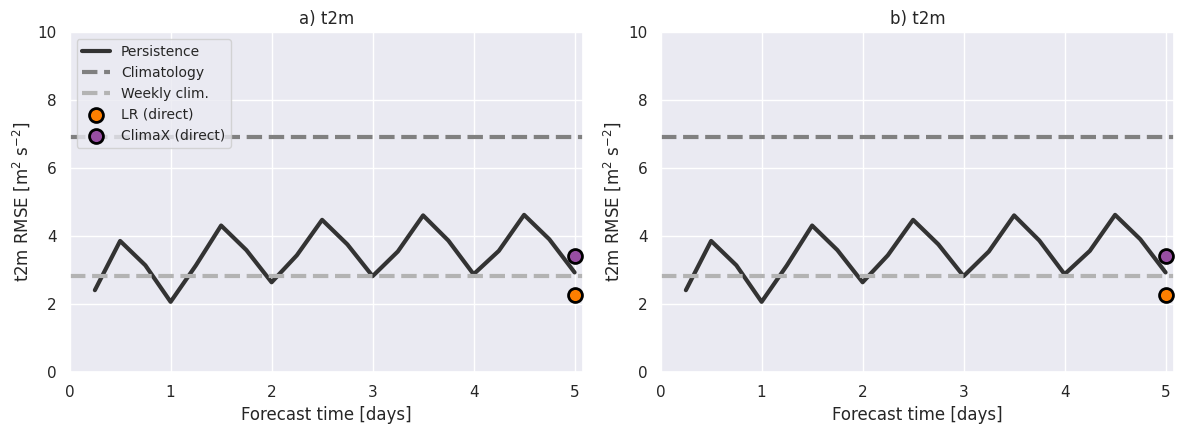

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
create_plot(rmse, 't2m', ax=ax1, ylabel=r't2m RMSE [m$^2$ s$^{-2}$]', title='a) t2m', ylim=(0, 10))
create_plot(rmse, 't2m', ax=ax2, ylabel=r't2m RMSE [m$^2$ s$^{-2}$]', title='b) t2m', ylim=(0, 10))
# create_plot(rmse, 't', ax=ax2, ylabel=r'T850 RMSE [K]', title='b) T850', ylim=(0, 6))
ax1.legend(loc=2, ncol=1, fontsize=10)
plt.tight_layout()
# fig.savefig(None, bbox_inches='tight')

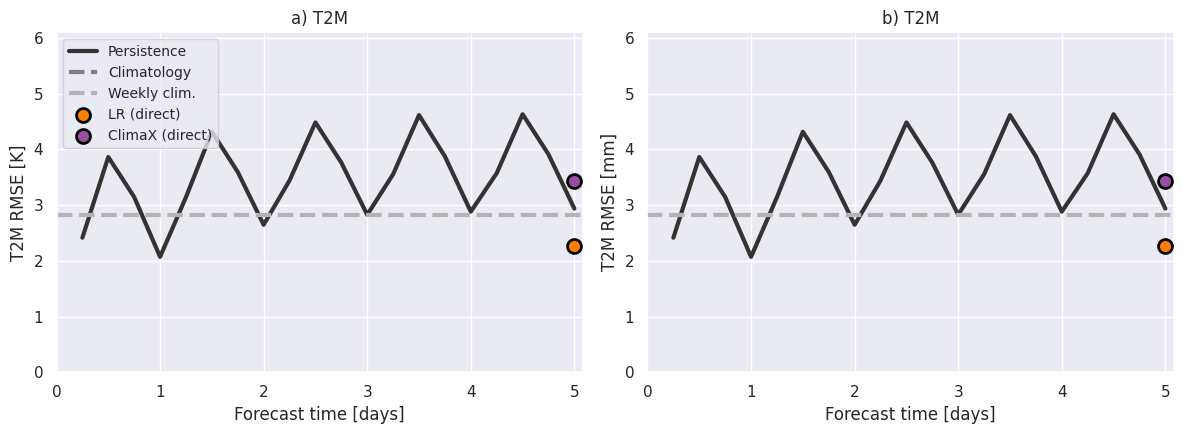

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
create_plot(rmse, 't2m', ax=ax1, ylabel=r'T2M RMSE [K]', title='a) T2M', ylim=(0, 6.1))
create_plot(rmse, 't2m', ax=ax2, ylabel=r'T2M RMSE [mm]', title='b) T2M', ylim=(0, 6.1))
ax1.legend(loc=2, ncol=1, fontsize=10)
plt.tight_layout()
# fig.savefig('../figures/rmse2.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


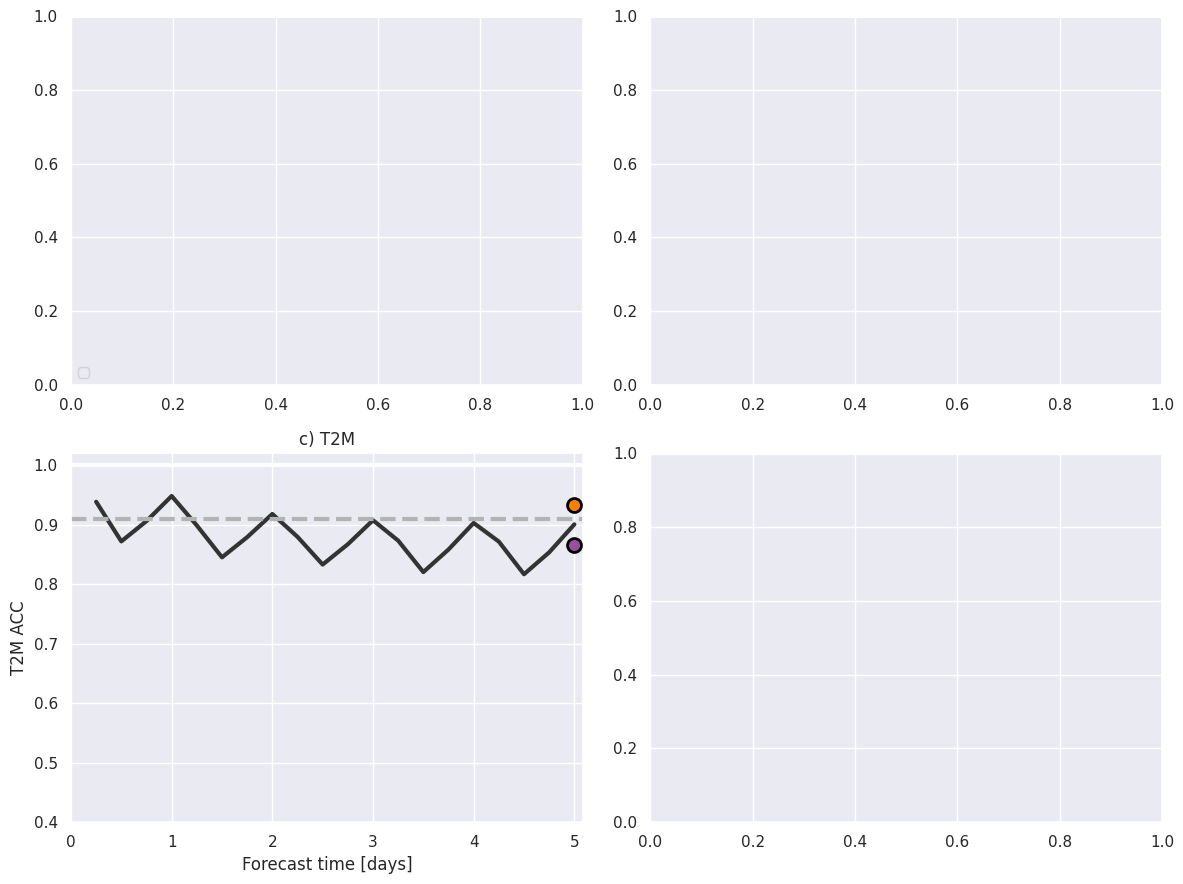

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
((ax1, ax2), (ax3, ax4)) = axs
# create_plot(acc, 'z', ax=ax1, ylabel=r'Z500 ACC', title='a) Z500', ylim=(0.5, 1.015))
# create_plot(acc, 't', ax=ax2, ylabel=r'T850 ACC', title='b) T850', ylim=(0.6, 1.01))
create_plot(acc, 't2m', ax=ax3, ylabel=r'T2M ACC', title='c) T2M', ylim=(0.4, 1.02))
# create_plot(acc, 'tp', ax=ax4, ylabel=r'TP ACC', title='d) TP', ylim=(0., 1.02))
ax1.legend(loc=3, ncol=1, fontsize=10)
for ax in axs.flat:
    ax.axhline(1, zorder=1, c='w', lw=3)
plt.tight_layout()
# fig.savefig('../figures/acc.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FileNotFoundError: [Errno 2] No such file or directory: '../figures/mae.pdf'

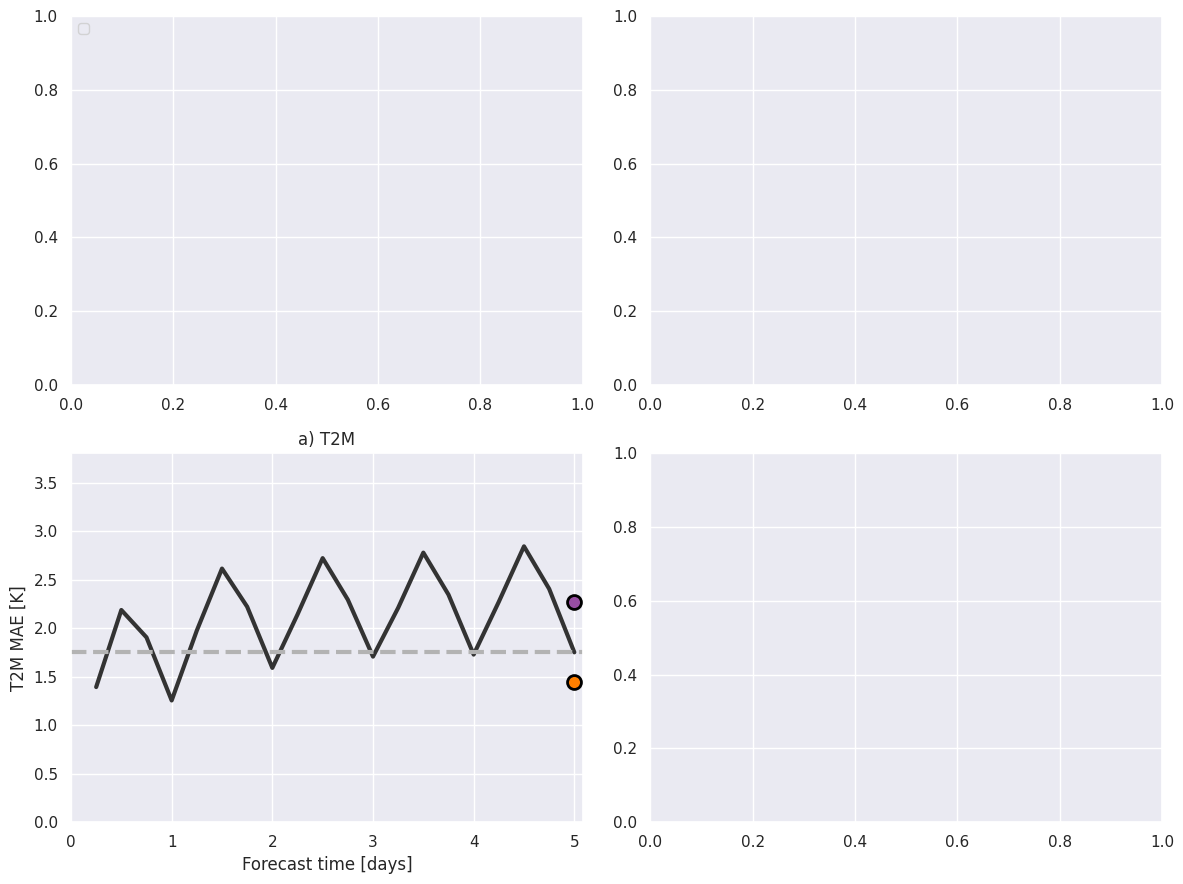

In [72]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
((ax1, ax2), (ax3, ax4)) = axs
# create_plot(mae, 'z', ax=ax1, ylabel=r'Z500 MAE [m$^2$ s$^{-2}$]', title='a) Z500', ylim=(0, 750))
# create_plot(mae, 't', ax=ax2, ylabel=r'T850 MAE [K]', title='b) T850', ylim=(0, 4))
create_plot(mae, 't2m', ax=ax3, ylabel=r'T2M MAE [K]', title='a) T2M', ylim=(0, 3.8))
# create_plot(mae, 'tp', ax=ax4, ylabel=r'TP MAE [mm]', title='b) TP', ylim=(0, 1.15), mult_tp=1e3)
ax1.legend(loc=2, ncol=1, fontsize=10)
plt.tight_layout()
fig.savefig('../figures/mae.pdf', bbox_inches='tight')

In [16]:
# for tables. Yeah I know ugly formatting...
for k, v in rmse.items():
    if hasattr(v, 'lead_time'):
        print(k, v.sel(lead_time=[12]).to_dataframe())
    else:
        print(k, v)

Persistence                 t2m
lead_time          
6          2.324909
Climatology <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    t2m      float64 5.98
Weekly clim. <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    t2m      float64 3.018
LR (iterative) Empty DataFrame
Columns: []
Index: [6]
CNN (iterative) Empty DataFrame
Columns: []
Index: [6]


KeyError: "not all values found in index 'lead_time'"

In [74]:
# for tables
for k, v in acc.items():
    if hasattr(v, 'lead_time'):
        df = v.sel(lead_time=[120]).to_dataframe().round(2)

        print(k, df)
    else:
        print(k, v)

Persistence            t2m
lead_time     
120        0.9
Climatology <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    t2m      float64 -8.707e-08
Weekly clim. <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    t2m      float64 0.9101
LR (iterative) Empty DataFrame
Columns: []
Index: [120]
CNN (iterative) Empty DataFrame
Columns: []
Index: [120]
LR (direct)             t2m
lead_time      
120        0.93
CNN (direct) Empty DataFrame
Columns: []
Index: [120]
ClimaX (direct)             t2m
lead_time      
120        0.87


In [80]:
# for tables
for k, v in mae.items():
    if hasattr(v, 'lead_time'):
        df = v.sel(lead_time=[120]).to_dataframe()
        try:
            df['tp'] *= 1000
        except KeyError:
            pass
        # df['z'] = df['z'].round()
        print(k, df.round(2))
    else:
        print(k, v)

Persistence             t2m
lead_time      
120        1.75
Climatology <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    t2m      float64 4.452
Weekly clim. <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    t2m      float64 1.751
LR (iterative) Empty DataFrame
Columns: []
Index: [120]
CNN (iterative) Empty DataFrame
Columns: []
Index: [120]
LR (direct)             t2m
lead_time      
120        1.44
CNN (direct) Empty DataFrame
Columns: []
Index: [120]
ClimaX (direct)             t2m
lead_time      
120        2.27


## Other figures for paper

In [18]:
import cartopy.crs as ccrs

In [19]:
sns.set_style('dark')

<xarray.DataArray 't2m' (lead_time: 20, time: 17328, lat: 32, lon: 64)>
[709754880 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Dimensions without coordinates: lead_time
<xarray.DataArray 't2m' (time: 17400, lat: 32, lon: 64)>
[35635200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-06 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4


AttributeError: Rectangle.set() got an unexpected keyword argument 'add_colorbar'

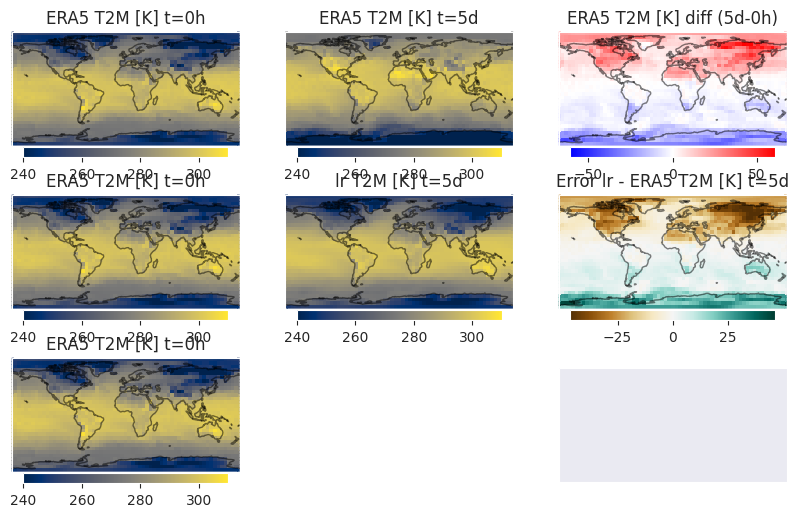

In [35]:
cmap_t2m = 'cividis'
cmap_t = 'RdYlBu_r'
cmap_diff = 'bwr'
cmap_error = 'BrBG'

def imcol(ax, data, title='', **kwargs):
    if not 'vmin' in kwargs.keys():
        mx = np.abs(data.max().values)
        kwargs['vmin'] = -mx; kwargs['vmax'] = mx
#     I = ax.imshow(data, origin='lower',  **kwargs)
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, 
                  rasterized=True, **kwargs)
    cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
    ax.set_title(title)
    ax.coastlines(alpha=0.5)

fig, axs = plt.subplots(3, 3, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# True
for iax, var, cmap, r, t in zip(
    [0], ['t2m'], [cmap_t2m], [[240, 310]], ['T2M [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], valid_data[var].isel(time=5*24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=5d')
    imcol(axs[iax,2], 
        valid_data[var].isel(time=5*24)-valid_data[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (5d-0h)')

# CNN
for iax, var, cmap, r, t in zip(
    [1], ['t2m'], [cmap_t2m], [[240, 310]], ['T2M [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], lr_5d[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'lr {t} t=5d')
    imcol(axs[iax,2], 
        lr_5d[var].isel(time=0) - valid_data[var].isel(time=5*24), cmap=cmap_error,
        title=f'Error lr - ERA5 {t} t=5d')
print(climax_12h['t2m'])
print(lr_5d['t2m'])
# ClimaX
for iax, var, cmap, r, t in zip(
    [2], ['t2m'], [cmap_t2m], [[240, 310]], ['T2M [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], climax_12h[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'lr {t} t=5d')
    imcol(axs[iax,2], 
        climax_12h[var].isel(time=0) - valid_data[var].isel(time=5*24), cmap=cmap_error,
        title=f'Error lr - ERA5 {t} t=5d')

for ax in axs.flat:
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(pad=0)
# plt.savefig('../figures/examples.pdf', bbox_inches='tight')
# plt.savefig('../figures/examples.jpeg', bbox_inches='tight', dpi=300)

In [ ]:
def plot_map(data, fn, cmap, vmin, vmax):
    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, 
                  add_labels=False, cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True)
    I.set_edgecolor('face')
    ax.set_xticks([]); ax.set_yticks([]); ax.coastlines(alpha=0.5, lw=2)
    plt.subplots_adjust(0, 0, 1, 1)
    fig.savefig(fn, bbox_inches=0, transparent='true')

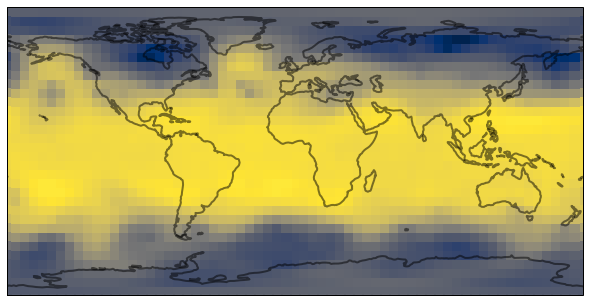

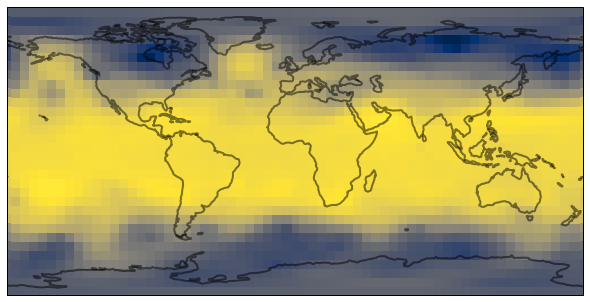

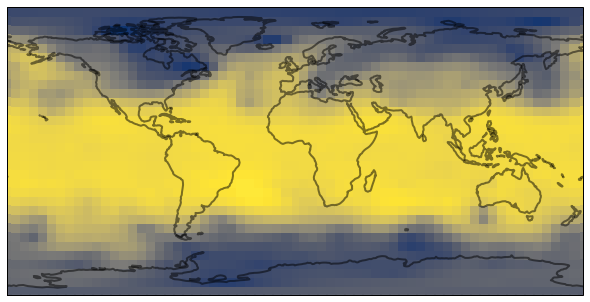

In [ ]:
plot_map(valid_data.z.isel(time=0), '../figures/z_0.pdf', 'cividis', 47000, 58000)
plot_map(valid_data.z.isel(time=6), '../figures/z_6h.pdf', 'cividis', 47000, 58000)
plot_map(valid_data.z.isel(time=5*24), '../figures/z_5d.pdf', 'cividis', 47000, 58000)

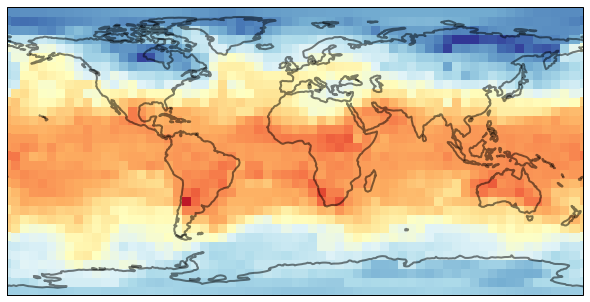

In [ ]:
plot_map(valid_data.t.isel(time=0), '../figures/t_0.pdf', 'RdYlBu_r', 240, 310)
plot_map(valid_data.t.isel(time=6), '../figures/t_6h.pdf', 'RdYlBu_r', 240, 310)
plot_map(valid_data.t.isel(time=5*24), '../figures/t_5d.pdf', 'RdYlBu_r', 240, 310)

# Same for higher resolutions

Let's now see how the number change if we do the same for higher resolutions.

In [ ]:
res = '2.8125'
DATADIR = f'/media/rasp/Elements/weather-benchmark/{res}deg/'
PREDDIR = '/data/weather-benchmark/predictions/'

In [ ]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature', 't')
valid_data = xr.merge([z500_valid, t850_valid])

In [ ]:
persistence = xr.open_dataset(f'{PREDDIR}persistence_{res}.nc')
climatology = xr.open_dataset(f'{PREDDIR}climatology_{res}.nc')
weekly_climatology = xr.open_dataset(f'{PREDDIR}weekly_climatology_{res}.nc')

In [ ]:
# Convert from geopotential height to geopotential
tigge_raw_z = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/tigge/{res}deg/z*.nc').squeeze()
tigge_raw_t = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/tigge/{res}deg/t*.nc').squeeze()

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
htt

In [ ]:
tigge_raw = xr.merge([tigge_raw_z.drop('lev'), tigge_raw_t.drop('lev')])

In [ ]:
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 30660)
Coordinates:
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-01-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>

In [ ]:
# Convert from geopotential height to geopotential
tigge_raw['z'] = tigge_raw.gh * 9.807
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 30660)
Coordinates:
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-01-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>
    z        (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>

In [ ]:
tigge_raw = tigge_raw.drop('gh')

In [ ]:
tigge = convert_time(tigge_raw, 21)

In [ ]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 64, lead_time: 21, lon: 128, time: 1460)
Coordinates:
  * lat        (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T12:00:00
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    t          (time, lead_time, lat, lon) float32 258.30826 ... 253.88545
    z          (time, lead_time, lat, lon) float32 50955.645 ... 49957.51

In [ ]:
# Save for later usage
tigge.to_netcdf(f'{PREDDIR}/tigge_{res}deg.nc')

In [ ]:
# See next section on how to compute these from the raw data.
tigge = xr.open_dataset(f'{PREDDIR}/tigge_{res}deg.nc')
# t21 = xr.open_dataset(f'{PREDDIR}/t21_5.625deg.nc')
# t42 = xr.open_dataset(f'{PREDDIR}/t42_5.625deg.nc')

In [ ]:
tigge_rmse = evaluate_iterative_forecast(tigge, valid_data).load()
# t21_rmse = evaluate_iterative_forecast(t21, valid_data).load()
# t42_rmse = evaluate_iterative_forecast(t42, valid_data).load()

In [ ]:
rmse_persistence = evaluate_iterative_forecast(persistence, valid_data).load()
rmse_climatology = compute_weighted_rmse(climatology, valid_data).load()
rmse_weekly_climatology = compute_weighted_rmse(weekly_climatology, valid_data).load()

In [ ]:
rmse = xr.merge(
    [r.rename({'z_rmse': f'z_{n}', 't_rmse': f't_{n}'}) for r, n in zip(
        [rmse_persistence, rmse_climatology, rmse_weekly_climatology, 
         tigge_rmse#, t42_rmse
        ],
        ['persistence', 'climatology', 'weekly_climatology',
         'tigge'#, 't42'
        ]
    )],
)

In [ ]:
rmse.to_netcdf(f'{PREDDIR}rmse_{res}.nc')

In [ ]:
for var in rmse:
    if 'lead_time' in rmse[var].coords:
        print(var, rmse[var].sel(lead_time=[3*24, 5*24]).values)

z_persistence [ 935.87036589 1033.14894667]
t_persistence [4.29551858 4.55898008]
t_tigge [1.35465153 2.03015878]
z_tigge [153.1443925  334.11416358]


In [ ]:
for var in rmse:
    if 'lead_time' not in rmse[var].coords:
        print(var, rmse[var].values)

z_climatology 1075.1918267920362
t_climatology 5.521677286348359
z_weekly_climatology 815.6050736811139
t_weekly_climatology 3.5057840813981054


The number are almost identical to the 5.625deg verification. I did not do the verification for 1.4 degrees yet but would expect the results to be similar. These results are reassuring and indicate that we can just verify at 5.625 degrees without losing too much information.

# The End